In [ ]:
import numpy as np
import pandas as pd

In [ ]:
pd.set_option('display.max_columns', None)

# **Input Data Creation**

# **Deriving James-Stein Shrinkage estimation Coefficient**

In [ ]:
def alpha_numerator(Z,S):
  s = 0
  T = Z.shape[1]
  for k in range(T):
    z = Z[:,k][:,np.newaxis]
    X = z @ z.T - S
    s += np.trace(X @ X)
  s /= (T**2)
  return s


def mean_shrinkage_JS(m_estim,S_estim,return_array):
  T  = return_array.shape[0]
  N = m_estim.shape[0]
  m = m_estim[:,np.newaxis]
  o = np.ones(N)[:,np.newaxis]
  iS = np.linalg.inv(S_estim)
  b = (o.T @ m / N)*o
  N_eff = np.trace(S_estim)/ np.max(np.linalg.eigvalsh(S_estim))
  alpha_num = max(N_eff - 3,0) ## it should not get negative
  alpha_den = T * (m - b).T @ iS @ (m - b)
  alpha = alpha_num/alpha_den
  m_shrunk = b + max(1 - alpha, 0) * (m - b)
  m_shrunk = m_shrunk[:, 0]

  return m_shrunk


def cov_shrinkage_LW(m_estim,S_estim,return_array):
  N = S_estim.shape[0]
  s2_avg = np.trace(S_estim)/N
  B = s2_avg * np.eye(N)
  Z = return_array.T  - m_estim[:,np.newaxis]
  alpha_num = alpha_numerator(Z,S_estim)
  alpha_den = np.trace((S_estim - B) @ (S_estim - B))
  alpha = alpha_num/alpha_den
  S_shrunk = (1 - alpha) * S_estim + alpha * B

  return S_shrunk

In [ ]:
def compute_inputs(
        list_df_prices,
        sample_period='W',
        investment_horizon=1,
        show_histograms=False,
        shrinkage=False,
        security_num=None,
        return_log=False
    ):
    map_period = {
        'W': 52
    }

    # We can generate return distribution based on multiple periods of price data
    if not isinstance(list_df_prices, list):
        list_df_prices = [list_df_prices]

    df_weekly_log_returns = pd.DataFrame()
    for df_prices in list_df_prices:
        # PREPROC: Remove factors
        if security_num is not None:
            df_prices = df_prices.iloc[:, 0:security_num]

        # 1. Compute weekly logarithmic return
        df_weekly_prices = df_prices.resample(sample_period).last()
        df_weekly_log_returns_part = np.log(df_weekly_prices) - np.log(df_weekly_prices.shift(1))
        df_weekly_log_returns_part = df_weekly_log_returns_part.dropna(how='all')
        df_weekly_log_returns_part = df_weekly_log_returns_part.fillna(0)

        df_weekly_log_returns = pd.concat([df_weekly_log_returns, df_weekly_log_returns_part], ignore_index=True)

    if show_histograms:
        df_weekly_log_returns.hist(bins=50)

    # 2. Compute the distribution of weekly logarithmic return
    return_array = df_weekly_log_returns.to_numpy()
    T = return_array.shape[0]
    m_weekly_log = np.mean(return_array, axis=0)
    S_weekly_log = np.cov(return_array.transpose())

    # Apply shrinkage if needed
    if shrinkage:
      m_weekly_log = mean_shrinkage_JS(m_weekly_log, S_weekly_log, return_array)
      S_weekly_log = cov_shrinkage_LW(m_weekly_log, S_weekly_log, return_array)

    # 3. Project the distribution to the investment horizon
    scale_factor = investment_horizon * map_period[sample_period]
    m_log = scale_factor * m_weekly_log
    S_log = scale_factor * S_weekly_log

    if return_log:
        return m_log, S_log

    # 4. Compute the distribution of yearly linear return
    p_0 = np.ones(len(m_log))  # We use a dummy price here to see the method in two steps. It will be canceled out later.
    m_P = p_0 * np.exp(m_log + 1/2*np.diag(S_log))
    S_P = np.outer(m_P, m_P) * (np.exp(S_log) - 1)

    m = 1 / p_0 * m_P - 1
    S = 1 / np.outer(p_0, p_0) * S_P

    return m, S

In [ ]:
import warnings
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.filterwarnings("ignore")

# 30 STOCKS

# **Getting the data first**

In [ ]:
from datetime import datetime
import yfinance as yf
#import matplotlib.pyplot as plt

# initialize parameters
start_date = datetime(2021, 1, 1)
end_date = datetime(2022, 1, 1)

assets = ['UNH','MSFT','GS','HD','CAT','CRM','AMGN','MCD','V','TRV','AXP','BA','HON','AAPL','IBM','JPM','WMT','PG','JNJ','CVX','MRK',
          'DIS','NKE','MMM','KO','DOW','CSCO','INTC','VZ','WBA']
# get the data
raw_data = yf.download(assets, start = start_date,
                   end = end_date)

data = raw_data.loc[:,('Adj Close', slice(None))]
data_volume = raw_data.loc[:,('Volume', slice(None))]
data.columns = assets
data_volume.columns = assets
data

[*********************100%%**********************]  30 of 30 completed


,UNH,MSFT,GS,HD,CAT,CRM,AMGN,MCD,V,TRV,AXP,BA,HON,AAPL,IBM,JPM,WMT,PG,JNJ,CVX,MRK,DIS,NKE,MMM,KO,DOW,CSCO,INTC,VZ,WBA
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-01-04,127.002106,204.389328,113.141541,202.720001,170.039993,220.309998,40.189514,73.948410,177.102798,46.685375,245.939270,245.347687,195.985260,101.472191,45.371323,143.276230,114.875854,48.158413,196.562454,148.233978,70.257324,211.605316,135.820648,127.131279,126.957176,335.248688,212.716629,48.899708,35.157169,139.870682
2021-01-05,128.572342,205.381226,113.745377,211.630005,171.430939,221.520004,40.207813,75.947464,177.860336,48.205845,251.442688,247.327805,196.465927,103.273384,46.229977,144.960739,115.500931,47.629002,197.740585,147.983856,70.378822,211.809448,136.916122,127.942993,125.908974,330.740417,209.541885,48.675362,34.953362,139.126129
2021-01-06,124.244392,210.331818,117.953209,211.029999,180.971466,216.149994,40.591782,78.391769,178.538116,50.477913,265.011169,248.740829,200.047256,105.852356,46.677563,146.324844,120.924377,46.113789,197.291763,150.234940,71.489616,206.317352,138.001938,129.289795,130.186111,344.620331,207.695694,49.265308,36.541374,139.994766
2021-01-07,128.483978,211.026199,117.020203,212.710007,181.316849,217.979996,41.103752,78.758408,177.999878,50.547024,270.672333,247.523041,200.377151,105.606720,47.673229,146.819214,124.895462,45.602623,198.208115,146.379654,72.912796,212.188522,140.522507,128.081390,130.158035,350.145447,208.858124,49.154461,38.435104,139.985184
2021-01-08,129.592987,215.056961,117.135635,209.899994,181.344879,222.039993,41.195171,79.509163,178.109528,50.287853,269.215271,250.153931,197.945587,105.230118,47.179970,146.517090,125.033325,46.624939,201.845383,143.705963,72.053673,213.481354,141.879745,128.026047,130.700867,348.572357,210.460144,48.541386,38.392643,139.966110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,178.065674,209.327286,159.404984,203.169998,196.683807,258.299988,59.200478,109.134132,152.303635,50.445320,366.451294,383.501465,197.877213,118.388100,48.675095,159.248062,147.970337,55.222454,256.555603,157.237152,72.166016,335.668427,163.682892,153.166229,149.345154,485.869080,213.895523,45.756893,44.725552,136.499603
2021-12-28,177.038681,209.885040,159.424377,206.130005,196.912521,255.449997,59.303150,108.922813,154.695831,51.131527,366.045258,385.522919,198.471542,119.296555,48.506416,159.886307,148.419403,55.439014,256.211273,158.073639,72.392212,334.492188,162.549911,153.988922,150.378815,489.215210,214.308334,45.791645,45.342693,138.458466
2021-12-29,177.127579,211.586304,158.861954,203.660004,197.589172,254.539993,59.704548,108.362404,154.366898,51.519775,364.713715,389.907532,198.931641,119.944176,48.572014,161.012604,148.344574,55.504917,256.794708,158.758820,72.524162,335.178345,164.855011,155.265579,150.742493,491.783142,214.426254,45.478951,46.065636,138.390579


In [ ]:
WEIGHTS = [8.83,7.17,6.55,6.19,5.41,4.96,4.96,4.93,4.71,3.66,3.62,3.57,3.32,3.22,3.18,2.98,2.89,2.68,2.67,2.57,
           2.14,1.85,1.78,1.58,1.02,0.92,0.85,0.74,0.68,0.38] ### very important donot disturb these
WEIGHTS = np.array(WEIGHTS)
WEIGHTS = WEIGHTS/100

In [ ]:
## cross checking everything
sum(WEIGHTS), len(WEIGHTS), data.shape[1]

(1.0000999999999998, 30, 30)

# **DOW JONES INDUSTRIAL AVERAGE BENCHMARK RELATIVE PORTFOLIO OPTIMIZATION**

# **Creating Index value given its weight**

In [ ]:
bm = []

for index in range(data.shape[0]):
 value = np.array(data.iloc[index:index+1,]*WEIGHTS).sum(axis=1)
 bm.append(value[0])

In [ ]:
data['bm'] = bm

In [ ]:
## creating factor model to get our betas,variance of benchmark return,residual risk (which is variance of theta x)
import statsmodels.api as sm

def factor_model(scenario_lin, factor_num):
  if factor_num < 1:
    print("No factor selected : Model UnProcedable")

  ## generate logarithmic scenarios on our database

  ## do linear regression
  params = []
  resid = []
  X = scenario_lin[:,-factor_num:]
  X = sm.add_constant(X, prepend=True)

  for k in range(N):
    y = scenario_lin[:,k]
    model = sm.OLS(y,X).fit()
    resid.append(model.resid)
    params.append(model.params)
  resid = np.array(resid)
  params = np.array(params)

  ## get parameter estimates
  a = params[:,1]
  B = params[:,0:factor_num]
  S_F = np.atleast_2d(np.cov(X[:,factor_num].T))
  S_theta = np.cov(resid)
  S_theta = np.diag(np.diag(S_theta))

  return a, B, S_F, S_theta


In [ ]:
# Number of factors
fnum = 1

# Number of securities (We subtract fnum to account for factors at the end of the price data)
N = data.shape[1] - fnum

# Get optimization parameters
m, S = compute_inputs(data, security_num=N)

In [ ]:
G = np.linalg.cholesky(S)

m_log, S_log = compute_inputs(data, return_log=True)

np.random.seed(12345)
scenarios_log = np.random.default_rng().multivariate_normal(m_log,S_log,100)
## convert it into linear returns
scenario_lin = np.exp(scenarios_log) - 1

a, B, _, _ = factor_model(scenario_lin, fnum)

In [ ]:
m_log

array([ 0.30825821, -0.02843947,  0.30924533, -0.04255382,  0.08456591,
        0.13763528,  0.36891424,  0.31047979, -0.14573997,  0.01858306,
        0.29987206,  0.46283275,  0.00987003,  0.13581073,  0.02313574,
        0.0933337 ,  0.17295828,  0.18224156,  0.24389985,  0.09710279,
        0.00252015,  0.44303153,  0.14020238,  0.19289054,  0.13850867,
        0.34397981,  0.01218945, -0.07426411,  0.18401615,  0.00250669,
        0.16317571])

In [ ]:
np.std(m_log)

0.15180519531411424

In [ ]:
np.std(a)

0.481992108172061

In [ ]:
## new one right now
a

array([ 1.01024834,  0.24938316,  1.61379705,  1.69907494,  1.18137522,
        1.0840082 ,  1.06369169,  1.08006025,  0.85831029,  1.30351947,
        1.55200093,  1.38709025,  0.86094615,  0.35762125,  0.56299701,
        0.37783902,  0.98981913,  0.51048954,  0.46895027,  0.78640748,
       -0.2234393 ,  1.17176676,  1.6683467 ,  0.23379662,  0.73285793,
        0.57649499,  0.75552059, -0.01228624,  1.05273327,  0.74660278])

In [ ]:
### variance in return scenarios without cov_shrinkage
np.std(scenario_lin)

0.3441594978376119

In [ ]:
! pip install mosek
from mosek.fusion import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 25.8 MB/s eta 0:00:00


In [ ]:
## lets start maximizing our alpha return
import sys
def Efficientfrontier(N, a, B, G, xbm, deltas, uh, ub, lh, lb):
  with Model("BenchMark Portfolio") as M:
    #M.setLogHandler(sys.stdout)

    ## start defining variables
    x = M.variable("x",N,Domain.greaterThan(0.0))
    s = M.variable("s",1,Domain.unbounded())

    xa = Expr.sub(x,xbm)


    ## writing down the constraints on upper bound (restricting my tracking error)
    M.constraint("lh-uh",xa,Domain.inRange(lh,uh))
    ## parent constraint
    M.constraint("Budget",Expr.sum(x),Domain.equalsTo(1.0))
    ## portfolio active beta constraint basically managing my risk
    portfolio_active_beta = Expr.sub(Expr.dot(B,x),1)
    M.constraint("Beta-Risk_Constraint",portfolio_active_beta, Domain.inRange(lb,ub))

    ## writing down the generic risk exposure
    M.constraint("Risk",Expr.vstack(s,1,Expr.mul(G.T,xa)),Domain.inRotatedQCone())

    ## delta andf objective function
    delta = M.parameter()
    M.objective("objective",ObjectiveSense.Maximize, Expr.sub(Expr.dot(a, x), Expr.mul(delta, s)))
    #M.objective("objective",ObjectiveSense.Maximize, Expr.dot(a, x))

    # Create DataFrame to store the results. Last security name (the SPY ETF) is removed.
    columns = ["delta", "obj", "return", "risk"] + data.columns[:-1].tolist()
    df_result = pd.DataFrame(columns=columns)
    for d in deltas:
      # Update parameter
      delta.setValue(d);

      # Solve optimization
      M.optserverHost("http://solve.mosek.com:30080")
      M.solve()

      # Check if the solution is an optimal point
      solsta = M.getPrimalSolutionStatus()
      if (solsta != SolutionStatus.Optimal):
          # See https://docs.mosek.com/latest/pythonfusion/accessing-solution.html about handling solution statuses.
          raise Exception("Unexpected solution status!")

      # Save results
      portfolio_return = a @ x.level()
      portfolio_risk = np.sqrt(2 * s.level()[0])
      row = pd.Series([d, M.primalObjValue(), portfolio_return, portfolio_risk] + list(x.level()), index=columns)
      df_result = pd.concat([df_result, row.to_frame().T], ignore_index=True)

    return df_result

In [ ]:
xbm = list(WEIGHTS)
uh = np.ones(N) * 0.7
lh = -np.ones(N) * 0.7
ub = 0.7
lb = -0.7

deltas = np.logspace(start=1, stop=2, num=20)[::-1]

df_result = Efficientfrontier(N, a, B, G, xbm, deltas, uh, ub, lh, lb)
df_result

,delta,obj,return,risk,UNH,MSFT,GS,HD,CAT,CRM,AMGN,MCD,V,TRV,AXP,BA,HON,AAPL,IBM,JPM,WMT,PG,JNJ,CVX,MRK,DIS,NKE,MMM,KO,DOW,CSCO,INTC,VZ,WBA
0,100.000000,0.608128,1.189196,0.107802,4.374799e-11,8.232936e-12,0.068763,6.432036e-14,-1.696254e-11,-2.521545e-11,2.198849e-01,1.755621e-01,-7.624582e-12,2.780876e-12,0.027021,0.175729,-7.331274e-13,1.046472e-10,-5.556117e-12,-7.952101e-11,3.810016e-11,9.157685e-12,1.328775e-10,-1.736951e-11,1.386421e-11,0.297401,1.718991e-12,2.380223e-11,-2.498113e-11,3.563837e-02,2.226838e-12,-8.611820e-11,4.667938e-11,-2.800020e-10
1,88.586679,0.674936,1.197761,0.108645,4.008514e-10,7.583455e-11,0.071242,1.038572e-10,-3.398030e-11,-5.487949e-11,2.206179e-01,1.712564e-01,1.425737e-12,8.572841e-11,0.029331,0.179892,3.369416e-11,6.715779e-10,-1.678717e-12,-3.822194e-10,2.560552e-10,9.537205e-11,7.909196e-10,-4.984957e-11,8.853675e-11,0.301059,8.725202e-11,1.269272e-10,-8.134133e-11,2.660237e-02,5.002560e-11,-4.316427e-10,2.973424e-10,-1.516828e-09
2,78.475997,0.735159,1.207433,0.109709,5.730061e-10,1.212430e-10,0.074039,2.054834e-10,-6.508978e-11,-9.309932e-11,2.214232e-01,1.664063e-01,3.603295e-12,1.696867e-10,0.031942,0.184588,6.049632e-11,8.823482e-10,-4.708611e-11,-6.971264e-10,4.245765e-10,1.714633e-10,1.201789e-09,-9.331210e-11,1.530452e-10,0.305202,1.745370e-10,2.136354e-10,-9.895801e-11,1.639891e-02,9.841856e-11,-8.172871e-10,5.334850e-10,-3.033191e-09
3,69.519280,0.789682,1.218333,0.111049,1.629639e-11,3.421747e-12,0.077195,5.333678e-12,-2.677870e-12,-4.174900e-12,2.223212e-01,1.609233e-01,-3.890661e-13,4.865956e-12,0.034893,0.189886,1.723129e-12,1.952502e-11,-3.051399e-12,-2.368231e-11,1.242606e-11,5.211112e-12,3.299931e-11,-3.382722e-12,4.572352e-12,0.309867,5.574030e-12,6.515074e-12,-1.742283e-12,4.914369e-03,3.143218e-12,-2.821565e-11,1.748629e-11,-1.097393e-10
4,61.584821,0.839151,1.226193,0.112113,9.206337e-12,1.542313e-11,0.080795,4.370961e-11,-1.610369e-11,-3.281257e-11,2.195504e-01,1.537363e-01,-7.999555e-13,2.556338e-11,0.038372,0.194819,8.655747e-12,8.713997e-11,-1.723781e-11,-1.290906e-10,3.924535e-11,1.777900e-11,1.528215e-10,-2.116288e-11,1.964663e-11,0.312729,3.226831e-11,2.036546e-11,-1.592096e-11,7.613524e-09,1.464382e-11,-1.500554e-10,8.201980e-11,-5.416424e-10
5,54.555948,0.883657,1.232001,0.113005,-6.522558e-11,2.019426e-11,0.084885,9.433490e-11,-2.241900e-11,-5.552137e-11,2.138221e-01,1.449354e-01,1.894333e-12,3.692860e-11,0.042396,0.199665,1.376134e-11,1.123769e-10,-2.373207e-11,-1.882649e-10,2.341097e-11,1.601408e-11,1.961366e-10,-3.120826e-11,2.307749e-11,0.314297,5.428904e-11,1.326878e-11,-2.562188e-11,3.833140e-09,2.030455e-11,-2.150071e-10,1.204220e-10,-7.168548e-10
6,48.329302,0.923789,1.238559,0.114132,-3.874347e-11,1.085348e-11,0.089500,7.189361e-11,-1.120161e-11,-2.836837e-11,2.073418e-01,1.350027e-01,2.183673e-12,2.213975e-11,0.046945,0.205134,9.213805e-12,5.469551e-11,-1.449692e-11,-1.127421e-10,8.831663e-12,5.412642e-12,1.002996e-10,-1.762421e-11,1.055341e-11,0.316077,3.823213e-11,8.905712e-13,-1.469315e-11,5.450707e-10,1.265230e-11,-1.278189e-10,7.440650e-11,-4.141007e-10
7,42.813324,0.960137,1.245969,0.115553,1.918813e-10,5.300021e-11,0.094715,2.319630e-10,2.537280e-12,-3.585877e-11,1.999999e-01,1.237908e-01,1.465516e-11,1.337353e-10,0.052086,0.211302,5.759235e-11,1.470247e-10,-7.316663e-11,-4.720483e-10,2.233675e-10,5.281181e-11,3.686363e-10,-4.706136e-11,4.395071e-11,0.318107,2.063591e-10,1.074601e-11,-6.228313e-12,2.309677e-09,7.605905e-11,-5.585360e-10,3.094116e-10,-2.095870e-09
8,37.926902,0.993237,1.254327,0.117338,6.764132e-11,3.260424e-11,0.100598,1.686137e-10,-8.459265e-12,-3.081065e-11,1.917470e-01,1.111287e-01,6.793686e-12,9.336399e-11,0.057881,0.218272,4.070533e-11,8.110251e-11,-7.346996e-11,-3.951124e-10,1.666347e-10,2.008853e-11,2.569085e-10,-5.235658e-11,2.353859e-11,0.320373,1.631958e-10,-1.372843e-11,-1.850228e-11,9.109722e-10,5.505196e-11,-4.604904e-10,2.302530e-10,-1.700831e-09
9,33.598183,1.023574,1.263763,0.119573,6.988589e-11,4.738159e-11

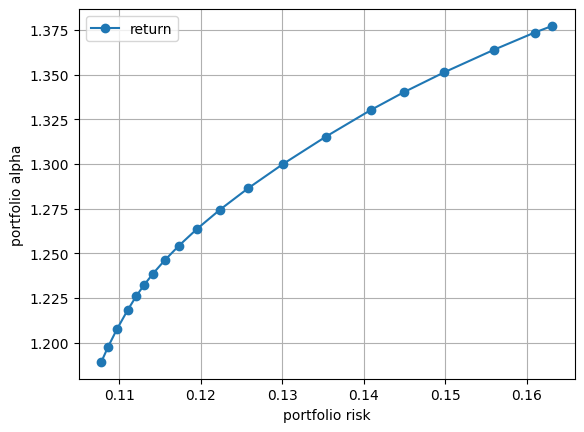

In [ ]:
ax = df_result.plot(x="risk", y="return", style="-o", xlabel="portfolio risk", ylabel="portfolio alpha", grid=True)

In [ ]:
change_in_holdings = df_result.iloc[:,4:] - xbm

In [ ]:
1-max(xbm), min(xbm)

(0.9117, 0.0038)

In [ ]:
lh, uh

(array([-0.7, -0.7, -0.7, -0.7, -0.7, -0.7, -0.7, -0.7, -0.7, -0.7, -0.7,
        -0.7, -0.7, -0.7, -0.7, -0.7, -0.7, -0.7, -0.7, -0.7, -0.7, -0.7,
        -0.7, -0.7, -0.7, -0.7, -0.7, -0.7, -0.7, -0.7]),
 array([0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7,
        0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7,
        0.7, 0.7, 0.7, 0.7]))

In [ ]:
l_xbm = xbm - lh
l_xbm

array([0.7883, 0.7717, 0.7655, 0.7619, 0.7541, 0.7496, 0.7496, 0.7493,
       0.7471, 0.7366, 0.7362, 0.7357, 0.7332, 0.7322, 0.7318, 0.7298,
       0.7289, 0.7268, 0.7267, 0.7257, 0.7214, 0.7185, 0.7178, 0.7158,
       0.7102, 0.7092, 0.7085, 0.7074, 0.7068, 0.7038])

In [ ]:
u_xbm = xbm + uh
u_xbm

array([0.7883, 0.7717, 0.7655, 0.7619, 0.7541, 0.7496, 0.7496, 0.7493,
       0.7471, 0.7366, 0.7362, 0.7357, 0.7332, 0.7322, 0.7318, 0.7298,
       0.7289, 0.7268, 0.7267, 0.7257, 0.7214, 0.7185, 0.7178, 0.7158,
       0.7102, 0.7092, 0.7085, 0.7074, 0.7068, 0.7038])

In [ ]:
WEIGHTS

array([0.0883, 0.0717, 0.0655, 0.0619, 0.0541, 0.0496, 0.0496, 0.0493,
       0.0471, 0.0366, 0.0362, 0.0357, 0.0332, 0.0322, 0.0318, 0.0298,
       0.0289, 0.0268, 0.0267, 0.0257, 0.0214, 0.0185, 0.0178, 0.0158,
       0.0102, 0.0092, 0.0085, 0.0074, 0.0068, 0.0038])

In [ ]:
m

array([ 0.40233978, -0.00673259,  0.42485461,  0.01833049,  0.11588081,
        0.19735734,  0.47373984,  0.4072465 , -0.11487565,  0.06259284,
        0.39309963,  0.63438007,  0.02421985,  0.1777587 ,  0.05515567,
        0.10659055,  0.21383522,  0.21210525,  0.28835652,  0.11404184,
        0.03306189,  0.58879533,  0.20120634,  0.2229556 ,  0.17372948,
        0.43905981,  0.04105119, -0.06350023,  0.249063  ,  0.01875539])

In [ ]:
a

array([ 1.01024834,  0.24938316,  1.61379705,  1.69907494,  1.18137522,
        1.0840082 ,  1.06369169,  1.08006025,  0.85831029,  1.30351947,
        1.55200093,  1.38709025,  0.86094615,  0.35762125,  0.56299701,
        0.37783902,  0.98981913,  0.51048954,  0.46895027,  0.78640748,
       -0.2234393 ,  1.17176676,  1.6683467 ,  0.23379662,  0.73285793,
        0.57649499,  0.75552059, -0.01228624,  1.05273327,  0.74660278])

In [ ]:
B = np.ravel(B)

In [ ]:
max(B), min(B)

(0.4029958293230722, -0.29783819795273325)

In [ ]:
study_frame = pd.DataFrame({'scrips':data.columns[:30],'weights_index':WEIGHTS,'return':m,'alpha':a,'beta': B})
study_frame

,scrips,weights_index,return,alpha,beta
0,UNH,0.0883,0.402340,1.010248,0.258517
1,MSFT,0.0717,-0.006733,0.249383,-0.046060
2,GS,0.0655,0.424855,1.613797,0.098366
3,HD,0.0619,0.018330,1.699075,-0.297838
4,CAT,0.0541,0.115881,1.181375,-0.109322
5,CRM,0.0496,0.197357,1.084008,-0.003212
6,AMGN,0.0496,0.473740,1.063692,0.269868
7,MCD,0.0493,0.407246,1.080060,0.191210
8,V,0.0471,-0.114876,0.858310,-0.272172
9,TRV,0.0366,0.062593,1.303519,-0.207018


In [ ]:
study_frame.to_excel("Data Given to the Model.xlsx",index=False)

In [ ]:
data.columns

Index(['UNH', 'MSFT', 'GS', 'HD', 'CAT', 'CRM', 'AMGN', 'MCD', 'V', 'TRV',
       'AXP', 'BA', 'HON', 'AAPL', 'IBM', 'JPM', 'WMT', 'PG', 'JNJ', 'CVX',
       'MRK', 'DIS', 'NKE', 'MMM', 'KO', 'DOW', 'CSCO', 'INTC', 'VZ', 'WBA',
       'bm'],
      dtype='object')

In [ ]:
df_result.iloc[11:12,4:]

,UNH,MSFT,GS,HD,CAT,CRM,AMGN,MCD,V,TRV,AXP,BA,HON,AAPL,IBM,JPM,WMT,PG,JNJ,CVX,MRK,DIS,NKE,MMM,KO,DOW,CSCO,INTC,VZ,WBA
11,9.085981e-10,1.474325e-10,0.12318,1.890430e-09,5.511310e-10,3.532893e-10,0.160065,0.062502,2.461525e-10,9.731673e-10,0.080144,0.245052,3.353313e-10,2.247535e-10,-1.157913e-10,-1.104534e-09,6.642136e-10,5.743436e-11,5.433078e-10,9.332667e-11,-3.581425e-11,0.329056,1.746648e-09,-2.134981e-10,-5.284367e-11,1.923461e-10,3.145007e-10,-1.321284e-09,1.859999e-09,-4.554332e-09


In [ ]:
index_alpha = (a * np.array(df_result.iloc[11:12,4:])[0]).sum()
index_alpha

1.2864240627693344

# **NOT A VERY DESIRED RESULT MOVING ON TO CVXPY**

# **Importing Mosek Solver License**

In [ ]:
from google.colab import files

# Upload the MOSEK license file
uploaded = files.upload()

import os
os.environ["MOSEKLM_LICENSE_FILE"] = "/content/mosek.lic"

!ls -l /content/mosek.lic

Saving mosek.lic to mosek.lic
-rw-r--r-- 1 root root 1030 Feb 17 10:31 /content/mosek.lic


In [ ]:
!pip install --upgrade cvxpy
!pip install cvxpy[mosek]
import cvxpy as cp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.7/227.7 kB 18.0 MB/s eta 0:00:00
  Attempting uninstall: cvxpy
    Found existing installation: cvxpy 1.3.3
    Uninstalling cvxpy-1.3.3:
      Successfully uninstalled cvxpy-1.3.3


In [ ]:
N = m.shape[0]
w = cp.Variable(N)
s = cp.Variable()
xbm = np.array(WEIGHTS)

## start writing objective function
constraint = [cp.sum(w) == 1]
constraint += [w - xbm <= 0.06] ## the constraint on allocation fraction
constraint += [w - xbm >= -0.01]
constraint += [w >= 0]
risk = (B * w - 1)
constraint += [risk <= 0.5] ## the constraint on risk beta taken on each portfolio
constraint += [cp.SOC(s,G.T @ (w - xbm))]
returns = cp.sum(w * a)
hedging = 0.015*s
prob = cp.Problem(cp.Maximize(returns-hedging),constraint)
prob.solve()

1.1760019105010493

In [ ]:
a

array([ 1.01024834,  0.24938316,  1.61379705,  1.69907494,  1.18137522,
        1.0840082 ,  1.06369169,  1.08006025,  0.85831029,  1.30351947,
        1.55200093,  1.38709025,  0.86094615,  0.35762125,  0.56299701,
        0.37783902,  0.98981913,  0.51048954,  0.46895027,  0.78640748,
       -0.2234393 ,  1.17176676,  1.6683467 ,  0.23379662,  0.73285793,
        0.57649499,  0.75552059, -0.01228624,  1.05273327,  0.74660278])

In [ ]:
cvxpy_sol = w.value

In [ ]:
cvxpy_sol[cvxpy_sol < 0.0005] = 0
cvxpy_sol

array([0.0783    , 0.0617    , 0.1255    , 0.1219    , 0.04410001,
       0.0396    , 0.0396    , 0.0393    , 0.0371    , 0.02660001,
       0.0962    , 0.03129999, 0.0232    , 0.0222    , 0.0218    ,
       0.0198    , 0.0189    , 0.0168    , 0.0167    , 0.0157    ,
       0.0114    , 0.00850001, 0.0778    , 0.0058    , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

# **A very distinct,balanced and optimal results**

In [ ]:
s.value

array(0.0538575)

In [ ]:
my_risk_to_tolerated = (np.diag(G)).sum()/N
my_risk_to_tolerated

0.1887239075548133

In [ ]:
risk.value

-0.9882438214112791

In [ ]:
bandwidth_used_by_solver = cvxpy_sol- xbm
bandwidth_used_by_solver

array([-0.01      , -0.01      ,  0.06      ,  0.06      , -0.00999999,
       -0.01      , -0.01      , -0.01      , -0.01      , -0.00999999,
        0.06      , -0.00440001, -0.01      , -0.01      , -0.01      ,
       -0.01      , -0.01      , -0.01      , -0.01      , -0.01      ,
       -0.01      , -0.00999999,  0.06      , -0.01      , -0.0102    ,
       -0.0092    , -0.0085    , -0.0074    , -0.0068    , -0.0038    ])

In [ ]:
max(bandwidth_used_by_solver), min(bandwidth_used_by_solver)

(0.06000000006078183, -0.0102)

In [ ]:
alpha_value = (a * cvxpy_sol).sum()
alpha_value

1.1766632030366462

In [ ]:
B

array([ 0.25851711, -0.04605969,  0.098366  , -0.2978382 , -0.10932181,
       -0.00321239,  0.26986839,  0.19120997, -0.27217174, -0.20701809,
        0.08773045,  0.37990374, -0.14448156,  0.07865251, -0.04597448,
        0.0383387 ,  0.01938803,  0.1073802 ,  0.181576  , -0.01839776,
        0.05630981,  0.40299583, -0.09980974,  0.16744945,  0.02545261,
        0.31832738, -0.10214122, -0.07978475,  0.03670601, -0.11514058])

In [ ]:
df = pd.DataFrame({'scrips':data.columns[:30],'index_weights':WEIGHTS,'individual_risk':np.sqrt(np.diag(G)),'mean_return':m,
                   'security_alpha':a,'Beta':B*cvxpy_sol,'solver_weights':cvxpy_sol,'difference':bandwidth_used_by_solver})
df.sort_values(by=['security_alpha'],ascending=False)

,scrips,index_weights,individual_risk,mean_return,security_alpha,Beta,solver_weights,difference
3,HD,0.0619,0.557924,0.018330,1.699075,-0.036306,0.1219,0.0600
22,NKE,0.0178,0.484191,0.201206,1.668347,-0.007765,0.0778,0.0600
2,GS,0.0655,0.651964,0.424855,1.613797,0.012345,0.1255,0.0600
10,AXP,0.0362,0.454957,0.393100,1.552001,0.008440,0.0962,0.0600
11,BA,0.0357,0.554424,0.634380,1.387090,0.011891,0.0313,-0.0044
9,TRV,0.0366,0.423948,0.062593,1.303519,-0.005507,0.0266,-0.0100
4,CAT,0.0541,0.455942,0.115881,1.181375,-0.004821,0.0441,-0.0100
21,DIS,0.0185,0.375058,0.588795,1.171767,0.003425,0.0085,-0.0100
5,CRM,0.0496,0.551291,0.197357,1.084008,-0.000127,0.0396,-0.0100
7,MCD,0.0493,0.475214,0.407246,1.080060,0.007515,0.0393,-0.0100


# **Now We will try with shrinkage factor to see the difference**

In [ ]:
## using shrinkage (mean shrinkage)
m_log, S_log = compute_inputs(data, return_log=True,shrinkage=True)

np.random.seed(12345)
scenarios_log = np.random.default_rng().multivariate_normal(m_log,S_log,100)
## convert it into linear returns
scenario_lin = np.exp(scenarios_log) - 1

a, B, _, _ = factor_model(scenario_lin, fnum)

In [ ]:
np.std(a)

0.2339682045872371

In [ ]:
np.std(m_log) ## without shrinkage

0.1516634702439631

In [ ]:
np.std(scenario_lin) ## without shrinkage

0.32056446948302453

In [ ]:
N = m.shape[0]
w = cp.Variable(N)
s = cp.Variable()
xbm = np.array(WEIGHTS)

## start writing objective function
constraint = [cp.sum(w) == 1]
constraint += [w - xbm <= 0.06] ## the constraint on allocation fraction
constraint += [w - xbm >= -0.01]
constraint += [w >= 0]
risk = (B.T * w - 1)
constraint += [risk <= 0.5] ## the constraint on risk beta taken on each portfolio
constraint += [cp.SOC(s,G.T @ (w - xbm))]
returns = cp.sum(w * a)
hedging = 0.015*s
prob = cp.Problem(cp.Maximize(returns-hedging),constraint)
prob.solve()

0.5813987284420814

In [ ]:
cvxpy_sol_skg = w.value

In [ ]:
cvxpy_sol_skg[cvxpy_sol_skg < 0.0005] = 0
cvxpy_sol_skg

array([0.0783    , 0.0617    , 0.06110001, 0.1219    , 0.04410001,
       0.0396    , 0.0396    , 0.10929999, 0.0371    , 0.0266    ,
       0.0962    , 0.0257    , 0.0232    , 0.0222    , 0.0218    ,
       0.0198    , 0.0189    , 0.0168    , 0.0167    , 0.0157    ,
       0.0114    , 0.0085    , 0.0778    , 0.0058    , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [ ]:
s.value

array(0.05173767)

In [ ]:
risk.value

array([-0.89194978])

In [ ]:
bandwidth_used_by_solver_skg = cvxpy_sol_skg- xbm
bandwidth_used_by_solver_skg

array([-0.01      , -0.01      , -0.00439999,  0.06      , -0.00999999,
       -0.01      , -0.01      ,  0.05999999, -0.01      , -0.01      ,
        0.06      , -0.01      , -0.01      , -0.01      , -0.01      ,
       -0.01      , -0.01      , -0.01      , -0.01      , -0.01      ,
       -0.01      , -0.01      ,  0.06      , -0.01      , -0.0102    ,
       -0.0092    , -0.0085    , -0.0074    , -0.0068    , -0.0038    ])

In [ ]:
max(bandwidth_used_by_solver_skg), min(bandwidth_used_by_solver_skg)

(0.05999999976561957, -0.0102)

In [ ]:
alpha_value_skg = (a * cvxpy_sol_skg).sum()
alpha_value_skg

0.5820965075589644

In [ ]:
df_skg = pd.DataFrame({'scrips_skg':data.columns[:30],'index_weights':WEIGHTS,'individual_risk':np.sqrt(np.diag(G)),'mean_return':m,
                   'security_alpha_skg':a,'solver_weights_skg':cvxpy_sol_skg,'difference':bandwidth_used_by_solver_skg})
df_skg.sort_values(by=['security_alpha_skg'],ascending=False)

,scrips_skg,index_weights,individual_risk,mean_return,security_alpha_skg,solver_weights_skg,difference
3,HD,0.0619,0.557924,0.018330,0.931632,0.1219,0.0600
22,NKE,0.0178,0.484191,0.201206,0.779136,0.0778,0.0600
10,AXP,0.0362,0.454957,0.393100,0.775804,0.0962,0.0600
7,MCD,0.0493,0.475214,0.407246,0.726628,0.1093,0.0600
2,GS,0.0655,0.651964,0.424855,0.711454,0.0611,-0.0044
4,CAT,0.0541,0.455942,0.115881,0.680572,0.0441,-0.0100
16,WMT,0.0289,0.347685,0.213835,0.667284,0.0189,-0.0100
9,TRV,0.0366,0.423948,0.062593,0.622313,0.0266,-0.0100
11,BA,0.0357,0.554424,0.634380,0.621136,0.0257,-0.0100
28,VZ,0.0068,0.475861,0.249063,0.566458,0.0000,-0.0068


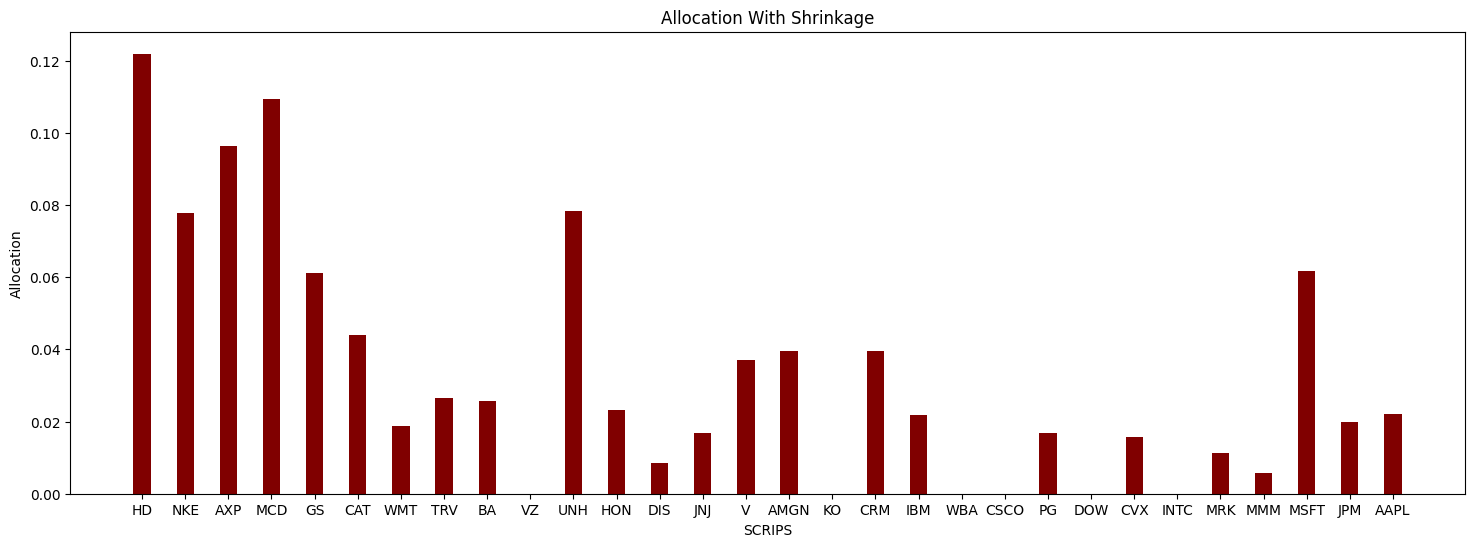

In [ ]:
df_skg = df_skg.sort_values(by=['security_alpha_skg'],ascending=False)
import matplotlib.pyplot as plt

plt.subplots(figsize =(18, 6))
plt.bar(df_skg.scrips_skg,df_skg.solver_weights_skg,color ='maroon',
        width = 0.4)
plt.xlabel('SCRIPS')
plt.ylabel("Allocation")
plt.title("Allocation With Shrinkage")
plt.show()

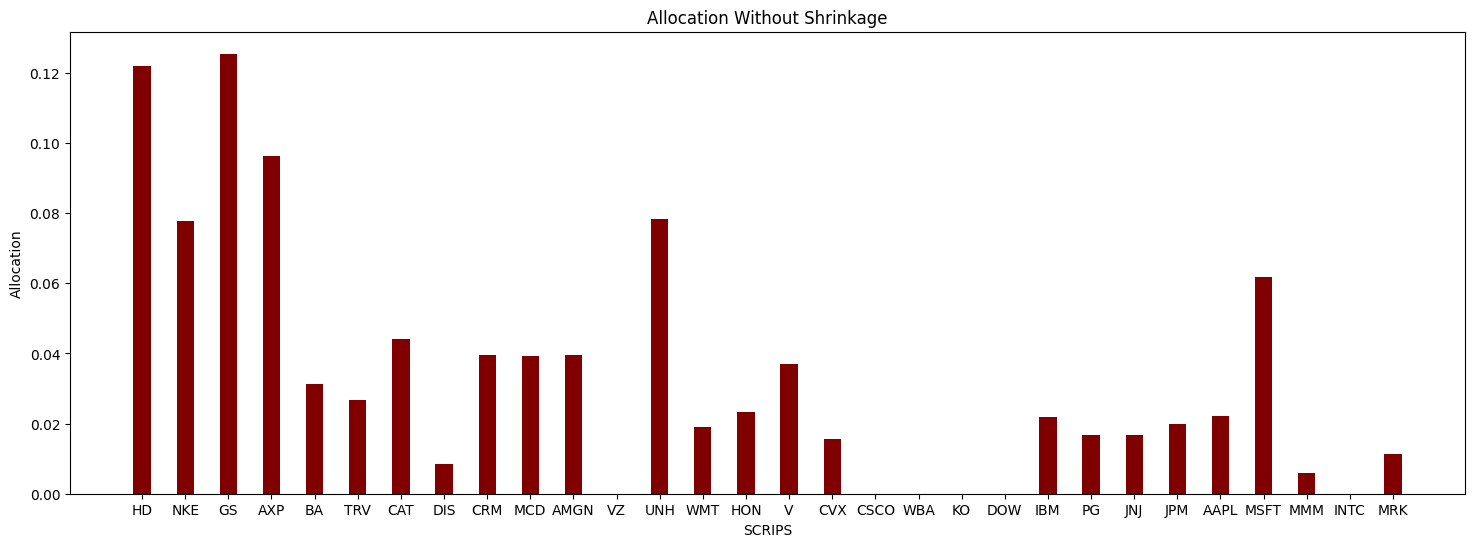

In [ ]:
df = df.sort_values(by=['security_alpha'],ascending=False)
import matplotlib.pyplot as plt

plt.figure(figsize=(18,6))
plt.bar(df.scrips,df.solver_weights,color ='maroon',
        width = 0.4)
plt.xlabel('SCRIPS')
plt.ylabel("Allocation")
plt.title("Allocation Without Shrinkage")
plt.show()